# Perfect Classifier results analysis
This notebook can be used to visualise performance of the perfect classifier, after cross-validated classification was performed.

## Imports and required function definitions

In [1]:
import os

from joblib import Parallel, delayed
import qiime2
import biom
import numpy as np
import pandas as pd
import seaborn as sns
from qiime2.plugins import feature_table
from qiime2.plugins import taxa
import matplotlib.pyplot as plt

from statsmodels.stats.weightstats import DescrStatsW
from scipy.stats import t, sem
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy.stats import wilcoxon, ranksums
from itertools import combinations as iter_combinations

from glob import glob
import json

from q2_quality_control._evaluate_taxonomy import _evaluate_taxonomy
from q2_quality_control._utilities import (
    _evaluate_composition, _compute_per_level_accuracy, _match_samples_by_index, _drop_nans_zeros)

%matplotlib inline

In [2]:
def _calc_prf(exp_taxa, obs_taxa, table):
    # calculate weighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=table,
        sample_id=None)
    prf['method'] = 'weighted'
    prf_results = prf

    # calculate unweighted PRF
    prf = _evaluate_taxonomy(
        exp_taxa=exp_taxa,
        obs_taxa=obs_taxa,
        require_exp_ids=True,
        require_obs_ids=True,
        feature_table=None,
        sample_id=None)
    prf['method'] = 'unweighted'
    prf_results = pd.concat([prf_results, prf])
    
    return prf_results


def _collapse_frequency_table_to_relative_frequency(table, taxonomy, level=7):
    for level in range(level, 0, -1):
        # to cater for truncated classifications
        try:
            table_l7 = taxa.methods.collapse(table=table, level=level, taxonomy=taxonomy)
            break
        except ValueError:
            pass
    rel_freq = feature_table.methods.relative_frequency(table_l7.collapsed_table)
    obs_table = rel_freq.relative_frequency_table.view(pd.DataFrame)
    return obs_table


def _eval_comp_basic(exp, obs, depth=7):
    exp, obs = _match_samples_by_index(exp, obs)

    # DROP NANS/ZERO ABUNDANCE FEATURES
    obs = _drop_nans_zeros(obs)
    exp = _drop_nans_zeros(exp)

    for depth in range(depth, 0, -1):
        # TAR/TDR for obs vs. exp at each level
        try:
            results, vectors = _compute_per_level_accuracy(exp, obs, metadata=None, depth=depth)
            break
        except ValueError:
            pass
    return results


def _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp):
    table_fp = os.path.join(frequencies_dir, fn)
    table = qiime2.Artifact.load(table_fp)
    rel_freq = feature_table.methods.relative_frequency(table)
    rel_freq.relative_frequency_table.save(rel_freq_fp)
    table = rel_freq.relative_frequency_table.view(biom.Table)
    return table


def _eval_for_class_weights(
    cw, type_dir, expected_dir, fns, frequencies_dir, relative_frequencies_dir):
    prf_results = pd.DataFrame()
    eval_results = pd.DataFrame()
    if cw == sample_type:
        return prf_results, eval_results

    cw_dir = os.path.join(type_dir, cw)
    # evaluate taxonomy
    for fn in fns:
        if fn in ['log', 'log_missed']:
            continue
        sample, _ = os.path.splitext(fn)

        # convert table to relative frequencies
        rel_freq_fp = os.path.join(relative_frequencies_dir, fn)
        if not os.path.exists(rel_freq_fp):
            table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)
        else:
            try:
                table = qiime2.Artifact.load(rel_freq_fp).view(biom.Table)
            except Exception as e:
                print(
                    f"An exception has occurred: {e}. Will try to recreate artifact."
                )
                table = _table_to_relative_freq(frequencies_dir, fn, rel_freq_fp)

        # load data
        exp_taxa_fp = os.path.join(expected_dir, fn)
        exp_taxa = qiime2.Artifact.load(exp_taxa_fp).view(pd.DataFrame)
        obs_taxa_fp = os.path.join(cw_dir, fn)
        obs_taxa = qiime2.Artifact.load(obs_taxa_fp).view(pd.DataFrame)

        results = _calc_prf(exp_taxa, obs_taxa, table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        prf_results = pd.concat([prf_results, results])

        # evaluate composition
        table_fp = os.path.join(frequencies_dir, fn)
        table = qiime2.Artifact.load(table_fp)
        exp_table = _collapse_frequency_table_to_relative_frequency(
            table, qiime2.Artifact.load(exp_taxa_fp))
        obs_table = _collapse_frequency_table_to_relative_frequency(
            table, qiime2.Artifact.load(obs_taxa_fp))

        results = _eval_comp_basic(exp_table, obs_table)
        results['class weights'] = cw
        results['sample type'] = sample_type
        results['sample'] = sample

        eval_results = pd.concat([eval_results, results])

    return prf_results, eval_results

def _check_sample_type(fns, df, class_weights, sample_type, is_prf=False):
    if len(df) == 0:
        return fns
    type_and_weight = df[df['sample type'] == sample_type]['sample']
    for_eval = []
    for fn in fns:
        levels = sum(type_and_weight == fn[:-4])
        m = 2 if is_prf else 1
        assert levels == 0 or levels == 7*m*(len(class_weights) - 1), \
            'got partial record for ' + fn
        if levels == 0:
            for_eval.append(fn)
    return for_eval

def _get_params_from_model(model_descriptor):
    # RandomForest/9-16-1000-sqrt-0.8
    # perfect-150-weighted-0.25        
    model_id, confidence, suffix, weights = None, None, None, None
    param_split = model_descriptor.split('-')
    model_id = param_split[0]
    confidence = float(param_split[-1])
    weights = param_split[-2]
    if len(param_split) == 4:
        suffix = param_split[1]
    return model_id, confidence, suffix, weights

def read_folds_info(folds_loc):
    test_seqs = {}
    for fold in glob(os.path.join(folds_loc, "*")):
        fold_base = fold.split("/")[-1]
        if fold_base.startswith("fold"):
            with open(os.path.join(fold, "sample_test.json")) as json_file:
                seq_ids = json.load(json_file)
                test_seqs[fold_base] = seq_ids
    test_seqs_map = {}
    for fold, seq_ids in test_seqs.items():
        for seq_id in seq_ids:
            if seq_id not in test_seqs_map.keys():
                test_seqs_map[seq_id] = fold.split("-")[-1]
            else:
                print(f"Sequence id {seq_id} already exists! - skipping")

    test_seqs_map_df = pd.DataFrame(test_seqs_map.items(), columns=["id", "fold"])
    return test_seqs_map_df

## Data sources and sample types
In order to run the analyses below, update the path to where your data is located (`project_dir`). Also, indicate which sample types you want to use in the analysis (corresponding directories need to exist within your project directory). Class weights paths will be discovered automatically - you should see them below.

Most of the analyses/figures presented here refer to only one sample type though, so only the first element of `sample_types` is usually taken into account.

In [3]:
project_dir = os.path.expandvars('/Users/mziemski/feature_classifier_paper/data/eval_perfect/')
sample_types = ['animal-distal-gut']

In [4]:
class_weights = []
for path in glob(os.path.join(project_dir, sample_types[0], 'results', 'PerfectClassifier', '*')):
    class_weights.append('/'.join(path.split('/')[-2:]))

In [5]:
class_weights

[]

## Run the evaluation

#### Evaluate cross-validation results or read the evaluation from file.

In [6]:
if os.path.exists(os.path.join(project_dir, 'eval_comp_results.tsv')):
    eval_comp_results = pd.read_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
else:
    eval_comp_results = pd.DataFrame()
if os.path.exists(os.path.join(project_dir, 'eval_taxa_prf.tsv')):
    prf_results = pd.read_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    prf_results = pd.DataFrame()

if not eval_comp_results.shape[0] > 0 and not prf_results.shape[0] > 0:
    for sample_type in sample_types:
        type_results = pd.DataFrame()
        type_dir = os.path.join(project_dir, sample_type, 'results')
        expected_dir = os.path.join(type_dir, 'expected')
        fns = os.listdir(expected_dir)
        frequencies_dir = os.path.join(type_dir, 'abundance')
        relative_frequencies_dir = os.path.join(type_dir, 'relative_frequencies')
        if not os.path.exists(relative_frequencies_dir):
            os.makedirs(relative_frequencies_dir)

        results = Parallel(n_jobs=5, verbose=50, batch_size=1)(
            delayed(_eval_for_class_weights)(
                cw, type_dir, expected_dir, fns, 
                frequencies_dir, relative_frequencies_dir) 
            for cw in class_weights)

        prf_list, eval_list = zip(*results)
        prf_results = pd.concat([prf_results] + list(prf_list))
        eval_comp_results = pd.concat([eval_comp_results] + list(eval_list))
        
        eval_comp_results.to_csv(os.path.join(project_dir, 'eval_comp_results.tsv'), sep='\t')
        prf_results.to_csv(os.path.join(project_dir, 'eval_taxa_prf.tsv'), sep='\t')
else:
    print("Evaluation results were loaded from a file.")

Evaluation results were loaded from a file.


In [7]:
print("Evaluation results shape:", eval_comp_results.shape, "and columns:", eval_comp_results.columns)
print("PRF results shape:", prf_results.shape)

Evaluation results shape: (788480, 17) and columns: Index(['Unnamed: 0', 'sample', 'level', 'Observed Taxa',
       'Observed / Expected Taxa', 'TAR', 'TDR', 'Slope', 'Intercept',
       'r-value', 'P value', 'Std Err', 'Bray-Curtis', 'Jaccard', 'r-squared',
       'class weights', 'sample type'],
      dtype='object')
PRF results shape: (2365440, 9)


In [8]:
prf_results["class weights"].unique()

array(['perfect-150-weighted-0.25', 'perfect-weighted-0.05',
       'perfect-weighted-0.5', 'perfect-weighted-0.95',
       'perfect-uniform-0.5', 'perfect-150-uniform-0.95',
       'perfect-150-uniform-0.25', 'perfect-uniform-0.95',
       'perfect-uniform-0.05', 'perfect-150-uniform-0.5',
       'perfect-150-weighted-0.95', 'perfect-150-uniform-0.75',
       'perfect-weighted-0.75', 'perfect-weighted-0.25',
       'perfect-uniform-0.75', 'perfect-150-weighted-0.05',
       'perfect-150-weighted-0.5', 'perfect-150-uniform-0.05',
       'perfect-150-weighted-0.75', 'perfect-uniform-0.25',
       'NaiveBayes/nb-uniform-0.7', 'NaiveBayes/nb-uniform-0.25',
       'NaiveBayes/nb-weighted-0.5', 'NaiveBayes/nb-weighted-0.25',
       'NaiveBayes/nb-uniform-0.5', 'NaiveBayes/nb-weighted-0.95',
       'NaiveBayes/nb-weighted-0.05', 'NaiveBayes/nb-weighted-0.7',
       'NaiveBayes/nb-uniform-0.95', 'NaiveBayes/nb-uniform-0.05'],
      dtype=object)

In [9]:
# clean up some stray columns (all starting with "Unnamed" - probably DF index that was repeatedly saved to file)
cols_to_keep = [col for col in eval_comp_results.columns if not col.startswith('Unnamed')]
eval_comp_results_clean = eval_comp_results[cols_to_keep]

cols_to_keep = [col for col in prf_results.columns if not col.startswith('Unnamed')]
prf_results_clean = prf_results[cols_to_keep]
prf_results_clean["model name"], prf_results_clean["confidence"], prf_results_clean["suffix"], prf_results_clean["weights"] = zip(
    *prf_results_clean["class weights"].apply(_get_params_from_model))

# save as a backup
#eval_comp_results_clean.to_csv(os.path.join(project_dir, 'eval_comp_results_cleaned.tsv'), sep='\t')
#prf_results_clean.to_csv(os.path.join(project_dir, 'eval_taxa_prf_cleaned.tsv'), sep='\t')

print(eval_comp_results_clean.shape, prf_results_clean.shape)

(788480, 16) (2365440, 12)


In [10]:
prf_results_clean.tail(2)

,level,Precision,Recall,F-measure,method,class weights,sample type,sample,model name,confidence,suffix,weights
2365438,6,0.789882,0.778691,0.784247,unweighted,NaiveBayes/nb-uniform-0.05,animal-distal-gut,11113.726.36782,NaiveBayes/nb,0.05,None,uniform
2365439,7,0.762822,0.762822,0.762822,unweighted,NaiveBayes/nb-uniform-0.05,animal-distal-gut,11113.726.36782,NaiveBayes/nb,0.05,None,uniform


#### Read in RF, CNN and additional NB data

In [11]:
data_rf_path = "/Users/mziemski/feature_classifier_paper/data/eval_rf/eval_taxa_prf_cleaned.tsv"
data_cnn_path = "/Users/mziemski/feature_classifier_paper/data/eval_cnn/eval_taxa_prf_cleaned.tsv"
data_nb_path = "/Users/mziemski/feature_classifier_paper/data/eval_nb/bens/eval_taxa_prf.tsv"

data_rf = pd.read_csv(data_rf_path, sep='\t', index_col=0)
data_cnn = pd.read_csv(data_cnn_path, sep='\t', index_col=0)
data_nb = pd.read_csv(data_nb_path, sep='\t', index_col=0)

/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)
/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
# remove NBC from the CNN table as those will be added in data_nb
data_cnn = data_cnn[~data_cnn["class weights"].str.startswith("nb")]

In [13]:
data_rf["weights"], data_cnn["weights"] = "weighted", "weighted"
data_nb.loc[data_nb["class weights"].str.endswith("uniform"), "weights"] = "uniform"
data_nb.loc[~data_nb["class weights"].str.endswith("uniform"), "weights"] = "weighted"

#### Read in information about the cross-validation folds.

In [14]:
test_seqs_map_df = read_folds_info(os.path.join(project_dir, sample_types[0], "tmp"))
print(test_seqs_map_df.head(2), test_seqs_map_df.shape)

test_seqs_map_df_rf = read_folds_info("/Users/mziemski/feature_classifier_paper/data/eval_rf/sediment-non-saline/tmp")
print(test_seqs_map_df_rf.head(2), test_seqs_map_df_rf.shape)

test_seqs_map_df_nb = read_folds_info("/Users/mziemski/feature_classifier_paper/data/eval_nb/animal-distal-gut/tmp")
print(test_seqs_map_df_nb.head(2), test_seqs_map_df_nb.shape)

test_seqs_map_df_cnn = read_folds_info("/Users/mziemski/feature_classifier_paper/data/eval_cnn/animal-distal-gut/tmp")
print(test_seqs_map_df_cnn.head(2), test_seqs_map_df_cnn.shape)

                                   id fold
0                     11113.441.36784    2
1  894.OS615.lane3.NoIndex.L003.30696    2 (5632, 2)
                       id fold
0  11757.G445224461.58900    2
1  11757.G440205035.58900    2 (22454, 2)
                                  id fold
0  894.UY46.lane3.NoIndex.L003.30696    2
1                    11113.802.36784    2 (5632, 2)
                                  id fold
0  894.UY46.lane3.NoIndex.L003.30696    2
1                    11113.802.36784    2 (5632, 2)


#### Read in information about abundance

In [15]:
abundance = pd.read_csv(os.path.join(project_dir, sample_types[0], "abundance.tsv"), sep='\t', index_col=0, header=None, squeeze=True, names=["sample", "abundance"]).astype(int, copy=False)
print(abundance.head(2))

abundance_rf = pd.read_csv(os.path.join("/Users/mziemski/feature_classifier_paper/data/eval_rf/sediment-non-saline", "abundances.tsv"), sep='\t', index_col=0, squeeze=True).astype(int, copy=False)
print(abundance_rf.head(2))

abundance_nb = pd.read_csv(os.path.join("/Users/mziemski/feature_classifier_paper/data/eval_nb/animal-distal-gut", "abundance.tsv"), sep='\t', index_col=0, header=None, squeeze=True, names=["sample", "abundance"]).astype(int, copy=False)
print(abundance_nb.head(2))

abundance_cnn = pd.read_csv(os.path.join("/Users/mziemski/feature_classifier_paper/data/eval_cnn/animal-distal-gut", "abundance.tsv"), sep='\t', index_col=0, header=None, squeeze=True, names=["sample", "abundance"]).astype(int, copy=False)
print(abundance_cnn.head(2))

sample
11113.393.36784                  10476
550.L1S248.s.1.sequence.30395     1200
Name: abundance, dtype: int64
sample
10184.10030521.61428      24829
11757.G440205218.58900    11254
Name: abundance, dtype: int64
sample
11113.393.36784                  10476
550.L1S248.s.1.sequence.30395     1200
Name: abundance, dtype: int64
sample
11113.393.36784                  10476
550.L1S248.s.1.sequence.30395     1200
Name: abundance, dtype: int64


#### Add folds and abundance data to the original df

In [16]:
def merge_folds_and_abundance(df_org, df_abundance, df_folds):
    org_with_folds = pd.merge(left=df_org, right=df_folds, left_on="sample", right_on="id")
    if org_with_folds.shape[0] != df_org.shape[0]:
        raise ValueError("Some samples were lost during merging fold information into original df.")
    else:
        print("Merge successful.")
        
    org_with_folds_abundance = pd.merge(left=org_with_folds, right=df_abundance, left_on="sample", right_index=True)
    if org_with_folds_abundance.shape[0] != org_with_folds.shape[0]:
        raise ValueError("Some samples were lost during merging abundance information into original df.")
    else:
        print("Merge successful.")
    
    return org_with_folds_abundance

In [17]:
data_rf_full = merge_folds_and_abundance(data_rf, abundance_rf, test_seqs_map_df_rf)

Merge successful.
Merge successful.


In [18]:
data_cnn_full = merge_folds_and_abundance(data_cnn, abundance_cnn, test_seqs_map_df_cnn)

Merge successful.
Merge successful.


In [19]:
data_nb_full = merge_folds_and_abundance(prf_results_clean[prf_results_clean["class weights"].str.startswith("NaiveBayes")], abundance_nb, test_seqs_map_df_nb)

Merge successful.
Merge successful.


In [20]:
data_nb_ben_full = merge_folds_and_abundance(data_nb, abundance_cnn, test_seqs_map_df_cnn)
data_nb_ben_full["model name"] = "nb"
data_nb_ben_full["confidence"] = 0.7

Merge successful.
Merge successful.


In [21]:
data_perfect_full = merge_folds_and_abundance(prf_results_clean[prf_results_clean["class weights"].str.startswith("perfect")], abundance, test_seqs_map_df)

Merge successful.
Merge successful.


In [22]:
all_data = pd.concat([data_rf_full, data_cnn_full, data_nb_full, data_nb_ben_full, data_perfect_full])
assert data_rf_full.shape[0] + data_cnn_full.shape[0] + data_nb_full.shape[0] + data_nb_ben_full.shape[0] + data_perfect_full.shape[0] == all_data.shape[0], "Data shape after merging does not match the expected shape."

/Users/mziemski/miniconda3/envs/paycheck/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [23]:
#all_data.to_csv(os.path.join(project_dir, 'prf_results_cleaned_all_models.tsv'), sep='\t', index=False)

## Visualise classification accuracy 
Run the cells below to generate plots showing various accuracy metrics of different samples and class weights (your classifiers) at all taxonomy levels. Only results of `weighted` analysis will be taken into account and used for plotting. All plots will be generated only for the `species` level (level 7).

In [24]:
level7 = all_data[all_data['level'] == 7]
level7_weighted = level7[level7['method'] == 'weighted']

In [25]:
print(level7_weighted.shape)
level7_weighted.head(2)

(987026, 19)


,F-measure,Precision,Recall,abundance,class weights,confidence,fold,id,level,max_depth,method,model name,model suffix,n_estimators,n_features,sample,sample type,suffix,weights
6,0.542004,0.985453,0.373797,24829,RandomForest/9-16-1000-sqrt-0.8,0.8,2,10184.10030521.61428,7,16,weighted,RandomForest9,NaN,1000.0,sqrt,10184.10030521.61428,sediment-non-saline,NaN,weighted
20,0.633478,0.967166,0.470982,24829,RandomForest/15-64-100-sqrt-0.8,0.8,2,10184.10030521.61428,7,64,weighted,RandomForest15,NaN,100.0,sqrt,10184.10030521.61428,sediment-non-saline,NaN,weighted


In [26]:
print(level7_weighted.loc[level7_weighted["abundance"].isnull(), "abundance"].sum())
print(level7_weighted.loc[level7_weighted["fold"].isnull(), "fold"].sum())
print(level7_weighted["class weights"].unique())

0
0
['RandomForest/9-16-1000-sqrt-0.8' 'RandomForest/15-64-100-sqrt-0.8'
 'RandomForest/12-16-1000-none-0.8' 'RandomForest/1-16-100-sqrt-0.6'
 'RandomForest/13-64-100-sqrt-0.6' 'RandomForest/8-16-1000-sqrt-0.7'
 'RandomForest/7-16-1000-sqrt-0.6' 'RandomForest/6-16-100-none-0.8'
 'RandomForest/14-64-100-sqrt-0.7' 'RandomForest/30-none-100-none-0.8'
 'RandomForest/3-16-100-sqrt-0.8' 'RandomForest/29-none-100-none-0.7'
 'RandomForest/nb-0.7' 'RandomForest/16-64-100-none-0.6'
 'RandomForest/nb-0.8' 'RandomForest/4-16-100-none-0.6'
 'RandomForest/10-16-1000-none-0.6' 'RandomForest/28-none-100-none-0.6'
 'RandomForest/nb-0.6' 'RandomForest/5-16-100-none-0.7'
 'RandomForest/18-64-100-none-0.8' 'RandomForest/17-64-100-none-0.7'
 'RandomForest/11-16-1000-none-0.7' 'RandomForest/2-16-100-sqrt-0.7'
 'RandomForest/c4-none-10-none-0.3' 'RandomForest/c5-none-100-none-0.5'
 'RandomForest/c4-none-100-none-0.4' 'RandomForest/c4-none-100-none-0.3'
 'Model4-0.95' 'Model2-0.95' 'Model1-0.7' 'Model9-0.7' '

Select best models.

In [27]:
best_models = ["RandomForest/c4-none-100-none-0.3", "Model6-0.5-10", "nb-150-uniform", "nb-150", "nb-uniform", "nb"]

selection1 = level7_weighted["class weights"].isin(best_models)
selection2 = level7_weighted["class weights"].str.startswith(("perfect",))

level7_weighted_selection = level7_weighted[selection1 | selection2]

In [28]:
level7_weighted_selection["class weights"].unique()

array(['RandomForest/c4-none-100-none-0.3', 'Model6-0.5-10',
       'nb-150-uniform', 'nb-150', 'nb', 'nb-uniform',
       'perfect-150-weighted-0.25', 'perfect-weighted-0.05',
       'perfect-weighted-0.5', 'perfect-weighted-0.95',
       'perfect-uniform-0.5', 'perfect-150-uniform-0.95',
       'perfect-150-uniform-0.25', 'perfect-uniform-0.95',
       'perfect-uniform-0.05', 'perfect-150-uniform-0.5',
       'perfect-150-weighted-0.95', 'perfect-150-uniform-0.75',
       'perfect-weighted-0.75', 'perfect-weighted-0.25',
       'perfect-uniform-0.75', 'perfect-150-weighted-0.05',
       'perfect-150-weighted-0.5', 'perfect-150-uniform-0.05',
       'perfect-150-weighted-0.75', 'perfect-uniform-0.25'], dtype=object)

Add MCC metric values

In [29]:
mcc_results_rf = pd.read_csv("/Users/mziemski/feature_classifier_paper/data/eval_rf/eval_taxa_prf_mcc.tsv", sep='\t', index_col=0)
mcc_results_other = pd.read_csv("/Users/mziemski/feature_classifier_paper/data/eval_cnn/eval_taxa_prf_mcc.tsv", sep='\t', index_col=0)

mcc_results = pd.concat([mcc_results_rf, mcc_results_other])
assert mcc_results.shape[0] == mcc_results_rf.shape[0] + mcc_results_other.shape[0]

In [30]:
mcc_results.head(2)

,level,MCC,method,class weights,sample type,sample
0,1,0.000000,weighted,RandomForest/1-16-100-sqrt-0.6,sediment-non-saline,10184.10040112.61426
1,2,0.963356,weighted,RandomForest/1-16-100-sqrt-0.6,sediment-non-saline,10184.10040112.61426


In [31]:
level7_weighted_selection_final = pd.merge(
    how="left",
    left=level7_weighted_selection, 
    right=mcc_results, 
    left_on=["class weights", "sample", "level", "method", "sample type"], 
    right_on=["class weights", "sample", "level", "method", "sample type"]
)
print("MCC values are missing for the following models:", level7_weighted_selection_final[level7_weighted_selection_final["MCC"].isnull()]["class weights"].unique())

MCC values are missing for the following models: []


### Metrics per taxonomic level

Generate one horizontal plot with selected models.

In [32]:
from matplotlib.ticker import AutoMinorLocator

def plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, model_order=None, save_loc=None):
    with sns.axes_style("whitegrid"):
        fig, axes = plt.subplots(1, 1)
        fig.set_size_inches(24, 5)

        # calculate mean metric for each fold by grouping by model
        # reset index to unstack all the levels from the multi-level index for easy plotting
        grouped_level7 = data.groupby(['model name', 'level', 'confidence', 'fold', "class weights"] + params)
        axis_data = grouped_level7.apply(weighted_stats, **{"metric": metric}).reset_index()
        axis_data.sort_values(["confidence"] + params, ascending=True, inplace=True)
        
        print(axis_data.head())
        
        # sort by confidence to plot in confidence groups
        if not model_order:
            all_models = axis_data["class weights"].unique()
            model_order = sorted(all_models, key=lambda x: x.rsplit("-", 1)[0])

        # set proper colours
        base_colors = sns.color_palette(palette, axis_data[params].drop_duplicates(inplace=False).shape[0])
        color_palette = base_colors[5:10] + (4 * base_colors[0:5])
        g = sns.boxplot(x="class weights", y=metric, data=axis_data, ax=axes, palette=color_palette, order=model_order)

        # set custom y ticks
        g.yaxis.set_ticks(np.arange(y_ticks_major[0], y_ticks_major[1], 0.1))
        if y_ticks_minor > 1:
            minor_locator = AutoMinorLocator(y_ticks_minor)
            g.yaxis.set_minor_locator(minor_locator)
            g.tick_params(which='minor', length=4)
            g.grid(True, which='minor', axis='y')

        # set some font sizes
        g.yaxis.label.set_size(15)
        for tick in g.yaxis.get_major_ticks():
            tick.label.set_fontsize(14)
        for tick in g.xaxis.get_major_ticks():
            tick.label.set_fontsize(14)
            tick.label.set_rotation(90)

        # relabel x-axis tick for easier identification
#         new_x_tick_labels = ["-".join(tick._text.split("/")[-1].split("-")[1:]) for tick in g.get_xticklabels()]
#         g.set_xticklabels(new_x_tick_labels)

        if save_loc:
            fig.savefig(save_loc, dpi=300)
            
        plt.show()
        
        return axis_data

def calculate_aggregate_metrics(axis_data, metric, grouping_column):
    axis_data_grouped = axis_data[[metric, grouping_column]].groupby(grouping_column)
    metric_table = pd.concat([axis_data_grouped.mean(), axis_data_grouped.sem(), axis_data_grouped.count()], axis=1)
    metric_table.columns = [f"Avg {metric}", "SEM", "Count"]
    return metric_table

def weighted_stats(x, metric):
    d1 = DescrStatsW(x[metric], weights=x['abundance'])
    return pd.Series([d1.mean], index=[metric])

def compare_all_wilcoxon(data_df, model_col, nb_prefix, metric, alpha, paired=False, correction=None):
    if "sample" in data_df.columns:
        data_stat = data_df[[metric, model_col, "sample", "fold", "abundance"]].sort_values([model_col, "sample"])
    else:
        data_stat = data_df[[metric, model_col]].sort_values([model_col])
    models = set(data_stat[model_col].unique())
    
    # find all pairs and only keep all vs NB
    combinations_init = list(iter_combinations(models, 2))
    combinations = []
    for comb in combinations_init:
        if comb[0].startswith(nb_prefix):
            combinations.append(comb)
        elif comb[1].startswith(nb_prefix) and not comb[0].startswith(nb_prefix):
            combinations.append((comb[1], comb[0]))
    combinations = sorted(combinations, key=lambda x: (x[0], x[1]))
         
    results = {}
    pvals, stats = [], []
    for comb in combinations:
        data_x = data_stat[data_stat[model_col] == comb[0]]
        data_y = data_stat[data_stat[model_col] == comb[1]]
        
        if paired and "sample" in data_stat.columns:
            # check that samples are the same and ordered
            assert data_x["sample"].reset_index(drop=True).equals(data_y["sample"].reset_index(drop=True)), "Sample IDs need to match."
            stat, pval = wilcoxon(data_x[metric], data_y[metric])
        else:
            stat, pval = ranksums(data_x[metric], data_y[metric])
        pvals.append(pval)
        stats.append(stat)
    
    results_df = pd.DataFrame({"group1": [x for x,y in combinations], "group2": [y for x,y in combinations], "stat": stats, "pval": pvals})
    
    # multiple test correction
    if correction:
        rejected, pvals_corr, _, _ = multipletests(pvals, alpha, correction)
        results_df["pval_corrected"], results_df["reject"] = pvals_corr, rejected
    else:
        results_df["pval_corrected"] = results_df["pval"]
        results_df["reject"] = results_df["pval"].apply(lambda x: True if x <= alpha else False)
    
    return results_df

In [33]:
model_order = [
    'RandomForest/c4-none-100-none-0.3', 'Model6-0.5-10', 'nb-150-uniform', 'nb-150', 'nb-uniform', 'nb',
    'perfect-150-uniform-0.05', 'perfect-150-uniform-0.25', 'perfect-150-uniform-0.5', 'perfect-150-uniform-0.75', 'perfect-150-uniform-0.95', 
    'perfect-150-weighted-0.05', 'perfect-150-weighted-0.25', 'perfect-150-weighted-0.5', 'perfect-150-weighted-0.75', 'perfect-150-weighted-0.95', 
    'perfect-uniform-0.05', 'perfect-uniform-0.25', 'perfect-uniform-0.5', 'perfect-uniform-0.75', 'perfect-uniform-0.95', 
    'perfect-weighted-0.05', 'perfect-weighted-0.25', 'perfect-weighted-0.5', 'perfect-weighted-0.75', 'perfect-weighted-0.95'
]

   model name  level  confidence fold              class weights  F-measure
32    perfect      7        0.05    0       perfect-uniform-0.05   0.914951
30    perfect      7        0.05    0   perfect-150-uniform-0.05   0.878922
34    perfect      7        0.05    1   perfect-150-uniform-0.05   0.875490
35    perfect      7        0.05    1  perfect-150-weighted-0.05   0.884353
36    perfect      7        0.05    1       perfect-uniform-0.05   0.915064


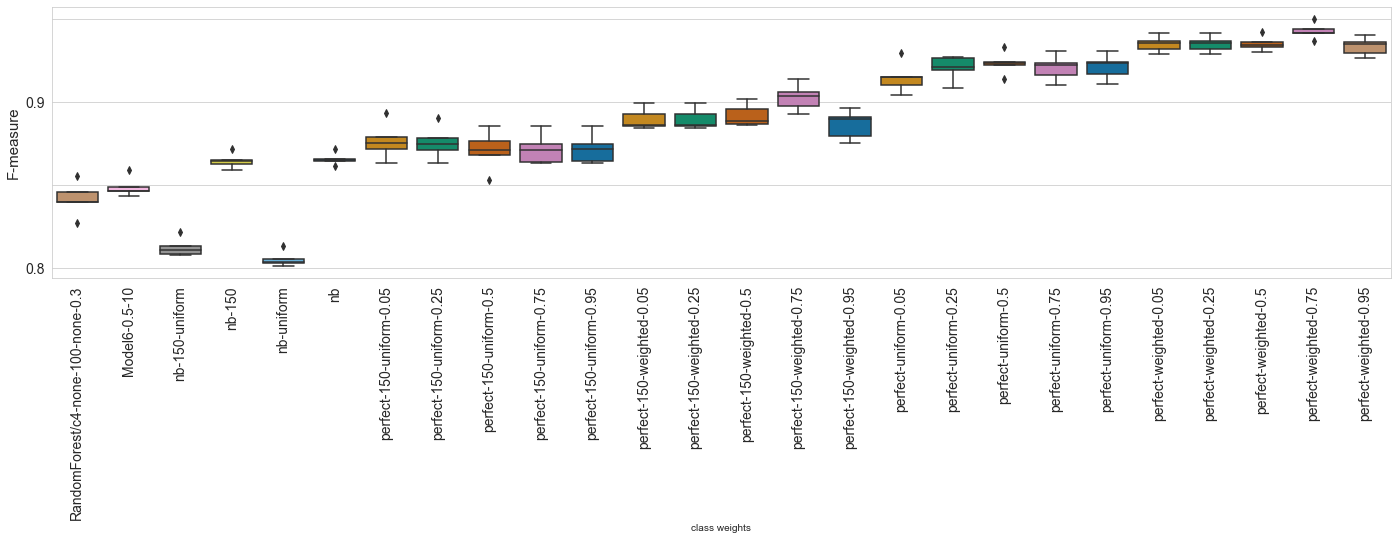

,Avg F-measure,SEM,Count
class weights,,,
Model6-0.5-10,0.848937,0.002691,5
RandomForest/c4-none-100-none-0.3,0.841880,0.004617,5
nb,0.865630,0.001659,5
nb-150,0.864722,0.002045,5
nb-150-uniform,0.812490,0.002456,5
nb-uniform,0.805436,0.002093,5
perfect-150-uniform-0.05,0.876527,0.004973,5
perfect-150-uniform-0.25,0.875621,0.004474,5
perfect-150-uniform-0.5,0.871020,0.005407,5


In [34]:
metric = "F-measure"
params = []
y_ticks_major = [0.80, 1.0]
y_ticks_minor = 2
other_columns = ["level", "model name", "confidence", "fold", "class weights", "weights", "abundance"]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-perfect-classifier-and-co.svg")
save_loc = None

data_slice = level7_weighted_selection_final[["F-measure", "Precision", "Recall", "MCC"] + params + other_columns]

selection1 = (data_slice["weights"].isin(["weighted", "uniform"]))
data = data_slice[selection1]

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, model_order=model_order, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

In [35]:
# append "pc-" to all class weights for the wilcoxon code to work
data["class weights modif"] = "pc-" + data["class weights"]

In [36]:
alpha = 0.05
correction = "hommel"
model_col = "class weights modif"
nb_prefix = "pc-"
save_loc = os.path.join(project_dir, sample_types[0], f"stats-rf-{metric}-{alpha}.tsv")
save_loc = None

stat_results_df = compare_all_wilcoxon(data, model_col, nb_prefix, metric, alpha, paired=False, correction=correction)

if save_loc:
     stat_results_df.to_csv(os.path.join(save_loc), sep='\t')

In [37]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(stat_results_df[~stat_results_df["reject"]])

,group1,group2,stat,pval,pval_corrected,reject
24,pc-RandomForest/c4-none-100-none-0.3,pc-perfect-150-uniform-0.75,0.197348,0.843555,0.999854,False
35,pc-nb-150,pc-nb,0.075331,0.939952,0.999854,False
39,pc-nb-150,pc-perfect-150-uniform-0.25,-0.593759,0.552673,0.999854,False
57,pc-nb-uniform,pc-nb-150-uniform,-2.733511,0.006266,0.125326,False
76,pc-perfect-150-uniform-0.25,pc-nb,0.605773,0.544666,0.999854,False
91,pc-perfect-150-uniform-0.5,pc-nb,0.515887,0.605933,0.999854,False
92,pc-perfect-150-uniform-0.5,pc-nb-150,0.511402,0.609070,0.999854,False
96,pc-perfect-150-uniform-0.5,pc-perfect-150-uniform-0.25,-0.068643,0.945274,0.999854,False
114,pc-perfect-150-uniform-0.95,pc-RandomForest/c4-none-100-none-0.3,0.279070,0.780191,0.999854,False
115,pc-perfect-150-uniform-0.95,pc-nb,-3.020578,0.002523,0.052981,False


   model name  level  confidence fold              class weights  Precision
32    perfect      7        0.05    0       perfect-uniform-0.05   0.918961
30    perfect      7        0.05    0   perfect-150-uniform-0.05   0.882202
34    perfect      7        0.05    1   perfect-150-uniform-0.05   0.878493
35    perfect      7        0.05    1  perfect-150-weighted-0.05   0.889847
36    perfect      7        0.05    1       perfect-uniform-0.05   0.918549


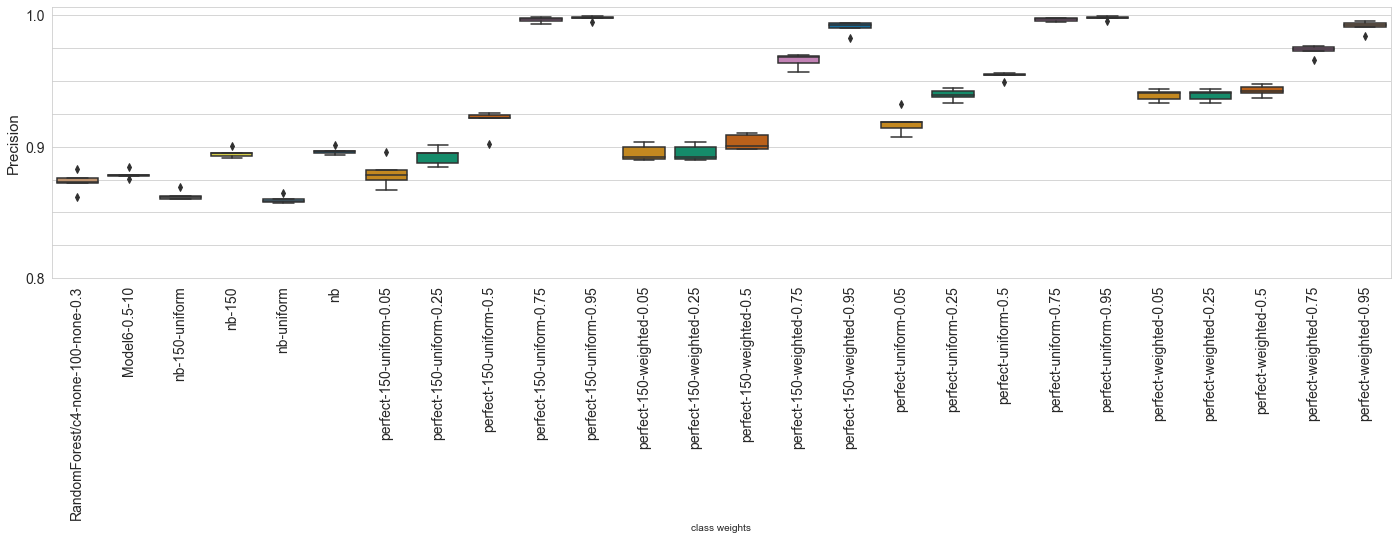

,Avg Precision,SEM,Count
class weights,,,
Model6-0.5-10,0.878877,0.001446,5
RandomForest/c4-none-100-none-0.3,0.873356,0.003365,5
nb,0.896771,0.001226,5
nb-150,0.894912,0.001588,5
nb-150-uniform,0.862798,0.001723,5
nb-uniform,0.859826,0.001407,5
perfect-150-uniform-0.05,0.879635,0.004749,5
perfect-150-uniform-0.25,0.892726,0.002902,5
perfect-150-uniform-0.5,0.919075,0.004328,5


In [38]:
metric = "Precision"
params = []
y_ticks_major = [0.8, 1.01]
y_ticks_minor = 4
other_columns = ["level", "model name", "confidence", "fold", "class weights", "weights"]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-perfect-classifier-and-co.svg")
save_loc = None

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, model_order=model_order, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

   model name  level  confidence fold              class weights    Recall
32    perfect      7        0.05    0       perfect-uniform-0.05  0.911207
30    perfect      7        0.05    0   perfect-150-uniform-0.05  0.875867
34    perfect      7        0.05    1   perfect-150-uniform-0.05  0.872658
35    perfect      7        0.05    1  perfect-150-weighted-0.05  0.879452
36    perfect      7        0.05    1       perfect-uniform-0.05  0.911771


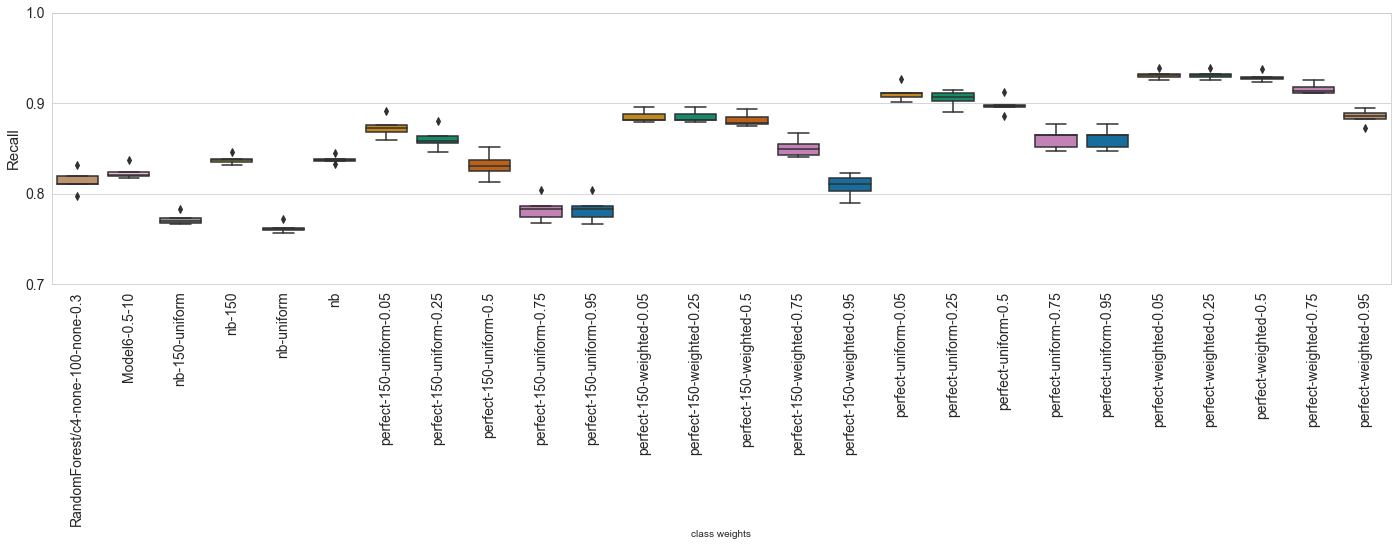

,Avg Recall,SEM,Count
class weights,,,
Model6-0.5-10,0.824141,0.003574,5
RandomForest/c4-none-100-none-0.3,0.814059,0.005553,5
nb,0.837856,0.001970,5
nb-150,0.837578,0.002392,5
nb-150-uniform,0.772119,0.002925,5
nb-uniform,0.762615,0.002668,5
perfect-150-uniform-0.05,0.873647,0.005165,5
perfect-150-uniform-0.25,0.861033,0.005627,5
perfect-150-uniform-0.5,0.831705,0.006473,5


In [39]:
metric = "Recall"
params = []
y_ticks_major = [0.7, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights", "weights"]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-perfect-classifier-and-co.svg")
save_loc = None

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, model_order=model_order, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

   model name  level  confidence fold              class weights       MCC
32    perfect      7        0.05    0       perfect-uniform-0.05  0.895510
30    perfect      7        0.05    0   perfect-150-uniform-0.05  0.853267
34    perfect      7        0.05    1   perfect-150-uniform-0.05  0.849814
35    perfect      7        0.05    1  perfect-150-weighted-0.05  0.859724
36    perfect      7        0.05    1       perfect-uniform-0.05  0.895502


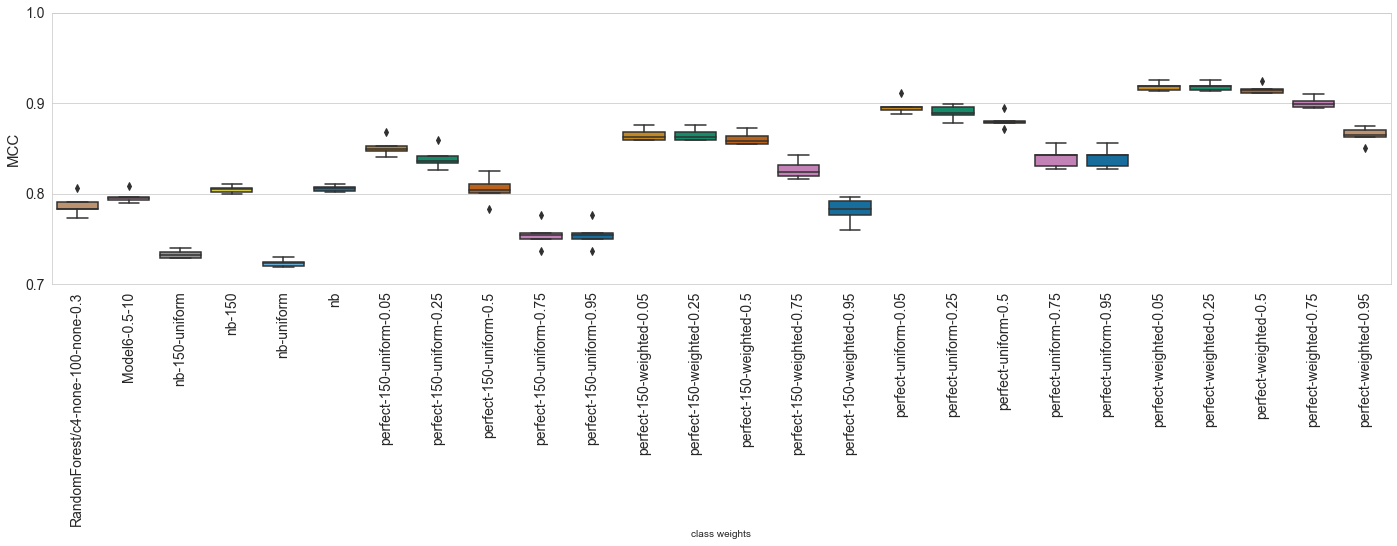

,Avg MCC,SEM,Count
class weights,,,
Model6-0.5-10,0.796451,0.003187,5
RandomForest/c4-none-100-none-0.3,0.787323,0.005422,5
nb,0.805906,0.001538,5
nb-150,0.804872,0.001878,5
nb-150-uniform,0.733385,0.002215,5
nb-uniform,0.723721,0.001858,5
perfect-150-uniform-0.05,0.851780,0.004726,5
perfect-150-uniform-0.25,0.839553,0.005394,5
perfect-150-uniform-0.5,0.804694,0.006839,5


In [40]:
metric = "MCC"
params = []
y_ticks_major = [0.7, 1.0]
y_ticks_minor = False
other_columns = ["level", "model name", "confidence", "fold", "class weights", "weights"]
palette = "colorblind"
save_loc = os.path.join(project_dir, sample_types[0], f"fig-{metric}-perfect-classifier-and-co.svg")
save_loc = None

axis_data = plot_all_boxes(data, metric, params, y_ticks_major, y_ticks_minor, palette, model_order=model_order, save_loc=save_loc)

calculate_aggregate_metrics(axis_data, metric, "class weights")

MCC metric was calculated using the [scikit-learn implementation.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)

Similarly to how it was done above, perform the Wilcoxon rank test on the MCC metric.

In [41]:
alpha = 0.05
correction = "hommel"
model_col = "class weights modif"
nb_prefix = "pc-"
save_loc = os.path.join(project_dir, sample_types[0], f"stats-rf-{metric}-{alpha}.tsv")
save_loc = None

stat_results_df = compare_all_wilcoxon(data, model_col, nb_prefix, metric, alpha, paired=False, correction=correction)

if save_loc:
     stat_results_df.to_csv(os.path.join(save_loc), sep='\t')

In [42]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(stat_results_df[~stat_results_df["reject"]])

,group1,group2,stat,pval,pval_corrected,reject
0,pc-Model6-0.5-10,pc-RandomForest/c4-none-100-none-0.3,-2.474479,0.013343,0.133431,False
21,pc-RandomForest/c4-none-100-none-0.3,pc-nb,-1.864400,0.062266,0.435859,False
34,pc-nb-150,pc-RandomForest/c4-none-100-none-0.3,2.461120,0.013850,0.134584,False
35,pc-nb-150,pc-nb,0.624789,0.532109,0.999896,False
50,pc-nb-150-uniform,pc-perfect-150-uniform-0.75,-2.715926,0.006609,0.079309,False
85,pc-perfect-150-uniform-0.25,pc-perfect-uniform-0.75,-2.049890,0.040375,0.282626,False
86,pc-perfect-150-uniform-0.25,pc-perfect-uniform-0.95,-2.118690,0.034117,0.249062,False
89,pc-perfect-150-uniform-0.5,pc-Model6-0.5-10,-2.636290,0.008382,0.092200,False
117,pc-perfect-150-uniform-0.95,pc-nb-150-uniform,2.665746,0.007682,0.084499,False
121,pc-perfect-150-uniform-0.95,pc-perfect-150-uniform-0.75,-0.037946,0.969730,0.999896,False
